# 1-An Introduction to OpenJij

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/OpenJij/OpenJijTutorial/blob/master/source/en/001-Introduction.ipynb)

OpenJij is a heuristic optimization library of the Ising model and QUBO.
It has a Python interface, therefore it can be easily written in Python, although the core part of the optimization is implemented with C++.

Let's install OpenJij by pip.   
(If you're using Colab, you'll need to install cmake first ``$ !pip install cmake``.)

In [30]:
# !pip install openjij

### The Ising model

The Ising model is a model treated in physics and is written as follows.

$$H(\{\sigma_i\}) = \sum_{i > j} J_{ij}\sigma_i \sigma_j + \sum_{i=1}^N h_i \sigma_i$$
$$\sigma_i \in \{-1, 1\}, i=1,\cdots N$$

$H(\{\sigma_i\})$ is called Hamiltonian, it is like an energy or a cost function.  
$\sigma_i$ is a binary variable it takes only two values $\{1, -1\}$.

> $\sigma_i$ corresponds to the physical quantity called spin in physics, it is sometimes called a spin variable or spin simply.
> Spin seems a micro magnet. The value of this variable corresponds to the physical state (the orientation of the magnet).
> $\sigma_i = -1$ means the magnet is up and 1 means magnet is down.


$H$ depends on the combination of variables $\{\sigma_i\} = \{\sigma_1, \sigma_2, \cdots, \sigma_N\}$.  
$J_{ij}, h_i$ represents the problem, and they are called interaction coefficients, longitudinal magnetic fields respectively.

OpenJij is a library which searches a combination of spin variables $\{\sigma_i\}$ that minimizes $H(\{\sigma_i\})$ when given $J_{ij}$ and $h_i$.

Let me show you a example.

## Solve a problem with OpenJij

We assume that the number of variables is $N=5$, 
and the longitudinal field and interaction are

$$h_i = -1~\text{for} ~\forall i, ~ J_{ij} = -1~\text{for} ~\forall i, j$$

respectively.

In this case, since all interaction coefficients are negative, the energy is lower when each spin variable takes the same value.
Also, since all longitudinal magnetic fields are negative, the energy is lower when each spin takes 1.
Therefore, we can predict the answer of this problem is $\{\sigma_i\} = \{1, 1, 1, 1, 1\}$.

Now let's solve the Ising model using OpenJij.

In [3]:
import openjij as oj

# Create interaction coefficients and longitudinal magnetic fields that represent the problem.
# OpenJij accepts problems in dictionary type.

N = 5
h = {i: -1 for i in range(N)}
J = {(i, j): -1 for i in range(N) for j in range(i+1, N)}

print('h_i: ', h)
print('Jij: ', J)

h_i:  {0: -1, 1: -1, 2: -1, 3: -1, 4: -1}
Jij:  {(0, 1): -1, (0, 2): -1, (0, 3): -1, (0, 4): -1, (1, 2): -1, (1, 3): -1, (1, 4): -1, (2, 3): -1, (2, 4): -1, (3, 4): -1}


In [4]:
# First, create an instance of Sampler to solve the problem.
sampler = oj.SASampler(num_reads=1)
# Solve the problem(h, J) by using the method of sampler.
response = sampler.sample_ising(h, J)

# The results (states) of calculation is in result.states.
print(response.states)

# If you want to see the result with subscript, use response.samples.
print([s for s in response.samples()])

[[1 1 1 1 1]]
[{0: 1, 1: 1, 2: 1, 3: 1, 4: 1}]


When dealing with large problem, you can also use numpy-based interface. The following form of matrix is assumed:

$$ \begin{pmatrix}
h_{0} & J_{0,1} & \cdots & J_{0,N-1}\\
J_{1,0} & h_{1} & \cdots & J_{1,N-1}\\
\vdots & \vdots & \vdots & \vdots\\
J_{N-1,0} & J_{N-1,1} & \cdots & h_{N-1}\\
\end{pmatrix} $$

In [1]:
#!pip install numpy -U

In [6]:
import numpy as np
mat = np.array([[-1,-0.5,-0.5,-0.5],[-0.5,-1,-0.5,-0.5],[-0.5,-0.5,-1,-0.5],[-0.5,-0.5,-0.5,-1]])
print(mat)

bqm = oj.BinaryQuadraticModel.from_numpy_matrix(mat, vartype='SPIN')
print(bqm)

sampler = oj.SASampler(num_reads=1)
response = sampler.sample(bqm)

print(response.states)

[[-1.  -0.5 -0.5 -0.5]
 [-0.5 -1.  -0.5 -0.5]
 [-0.5 -0.5 -1.  -0.5]
 [-0.5 -0.5 -0.5 -1. ]]
BinaryQuadraticModel({3: -1.0, 2: -1.0, 1: -1.0, 0: -1.0}, {(1, 2): -1.0, (2, 3): -1.0, (1, 3): -1.0, (0, 3): -1.0, (0, 2): -1.0, (0, 1): -1.0}, 0.0, Vartype.SPIN, sparse=False)
[[1 1 1 1]]


## Explanation of OpenJij

Then, I will explain the code showed above.
OpenJij has two interfaces currently. One of them used above is the same interface as D-Wave Ocean.
Therefore, if you get used to using OpenJij, easy changing to Ocean.

> Another interface will not be explained here, but it can be easily extended by using the structure of OpenJij (graph, updater, and algorithm) directly. 
> In the present situation, however, it would be sufficient to be able to use the interface which treated in the cell above.

### Sampler

In the above, we created an instance of Sampler after creating the problem in the dictionary type.

```python
sampler = oj.SASampler(num_reads=1)
```

Here, this Sampler is the object of selecting what algorithm and hardware you use.
When you want to try the other algorithm, change this Sampler.

> The algorithm treated in OpenJij is a heuristic and stochastic algorithm, it may return the different solutions each time the problem is solved, so it may not always obtain the optimal solution. 
> Therefore, we solve the problem many times and search for a good solution. So we call Sampler which means that we sample the solutions.

``SASampler`` treated in the above cell is a sampler that samples the solution by using an algorithm called ``Simulated annealing``.
For example, we can choose other samples below.

- SQASampler: An algorithm for simulating quantum annealing called Simulated Quantum Annealing (SQA) with a classical computer.

- GPUSQASampler: It runs SQA on GPU. It can treat only a special structure called Chimera graph.

### sample_ising(h, J)

When you want to solve the Ising model, you can use ``.sample_ising(h, J)``.
As I will explain later, when you treat QUBO which equivalent to the Ising model optimization, use ``.sample_qubo(Q)``.


### Response

``.sample_ising(h, J)`` returns the Response class.
This class contains results of solutions and energies that Sampler solved.

- .states:
    - type: list (list (int))
    - This list contains solutions to the number of iteration. > In physics, an array of spins called a state. Since .states stores the solutions to the number of iteration, we defined as .states from the meaning that multiple states are stored.

- .energies:
    - type: list (float)
    - This list contains the energy of each solution to the number of iteration.

The Response class inherits the SampleSet class of D-Wave's dimod. More detailed information can be found at the following links
[SampleSet: dimod documantation](https://docs.ocean.dwavesys.com/projects/dimod/en/latest/reference/sampleset.html).

Let's look at the acutual code.

In [3]:
# keys of h, J dictionaries can treat not only numbers.
h = {'a': -1, 'b': -1}
J = {('a', 'b'): -1, ('b', 'c'): 1}
# # Try solving 10 times by SA at a time. With the argument called num_reads.
sampler = oj.SASampler(num_reads=10)  
response = sampler.sample_ising(h, J)
print(response.first.sample)
print(response.first.energy)

{'a': 1, 'b': 1, 'c': -1}
-4.0


In [4]:
print(response.states)

[[ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]]


You can see that the response.states contains 10 solutions when you open it.
Since this problem is easy, returned the same answer is ``[1, -1, 1]`` every iterations.

> The parameters passed in the constructor such as ``num_reads`` can be overwritten by the method that executes sampling such as ``.sample_ising``.
>
> ```
> response = sampler.sample_ising(h, J, num_reads=2)
> response.states
> > [[1, 1, -1],[1, 1, -1]]
> ```

In [5]:
# Next, let's look the energies.
response.energies

array([-4., -4., -4., -4., -4., -4., -4., -4., -4., -4.])

Of course, the energies also take the same value every iterations.
The solutions in response.states are list type, so you confuse the corresponding to the strings ``"a", "b", "c"`` when you set the problem."
That is in response.variables.

In [7]:
response.variables

Variables(['a', 'b', 'c'])

``.first`` is useful if you only want to know the state with the lowest energy value.

In [8]:
response.first

Sample(sample={'a': 1, 'b': 1, 'c': -1}, energy=-4.0, num_occurrences=1)

## Let's try to solve QUBO

When you want to solve social problems,
it is often easier to formulate as QUBO(Quadratic Unconstraited Binary Optimization, ) than the Ising model.
Basically, it returns the same solution when using the Ising model.

> Also, QUBO is often called as UBQP (Unconstraited binary quadratic optimization problems).

QUBO is written as follows.

$$H(\{q_i\}) = \sum_{i\geq j} Q_{ij}q_i q_j$$
$$q_i \in \{0, 1\}$$

Binary variables take 0 or 1, that is difference between QUBO and the Ising model.

There are other ways to define $\sum$ and $Q_{ij}$ (for example, make $Q_{ij}$ a symmetric matrix), but in this time we have formulated it as above.

> The Ising model and QUBO are equivalent for the reason why they be converted to each other. You can convert these equation: $q_i=(\sigma_i + 1)/2$

In the case of QUBO, you search a combination of $\{q_i\}$ that minimizes $H(\{q_i\})$ under the $Q_{ij}$ which is given by a problem.

Also, since $q_i^2 = q_i$ (because $q_i$ takes only 0 or 1),
you can write as fllows

$$H(\{q_i\}) = \sum_{i > j} Q_{ij}q_i q_j + \sum_i Q_{ii} q_i$$

Namely, the diagonal components of $Q_{ij}$ is corresponds to the coefficients of the first-order term of $q_i$.

Let's solve QUBO with OpenJij

In [9]:
# Q_ij (dict)
Q = {(0, 0): -1, (0, 1): -1, (1, 2): 1, (2, 2): 1}
sampler = oj.SASampler()
# use .sample_qubo to solve QUBO
response = sampler.sample_qubo(Q)
print(response.states)

[[1 1 0]]


In QUBO, the solutions are made by 0 or 1 because the variables take 0 or 1.

## Let's solve a little difficult problem

You want to solve a problem of QUBO which has $Q_{ij}$ given by 50 random variables.

In [10]:
N = 100
# Create Q_ij randomly
import random
Q = {(i, j): random.uniform(-1, 1) for i in range(N) for j in range(i+1, N)}

# Solve by OpenJij
sampler = oj.SASampler()
response = sampler.sample_qubo(Q, num_reads=100)

In [11]:
# Look at some energies.
response.energies[:5]

array([-192.88732848, -192.88732848, -192.88732848, -192.88732848,
       -192.88732848])

You will realize that the energies takes a different values than before.
If you make $Q_{ij}$ randomly, the problem becomes difficult generally.
Therefore, SASampler does not necessarily give the same solution every time.
Now let's look at the histogram of energies.

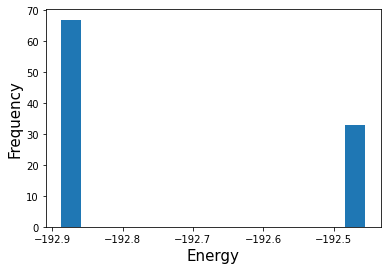

In [12]:
import matplotlib.pyplot as plt
plt.hist(response.energies, bins=15)
plt.xlabel('Energy', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

The lower the energy, the better, but you can find that the high energy solutions appear sometimes.
However, almost half of them seem to have the lowest energy.

Openjij solved the problem 100 times.
Since the optimal solution is the lowest energy,
the lowest energy solution among the solved (sampled) solutions should be close to the optimal solution.
Therefore, we search for the solution from ``.states``.

> Caution: SA can not always give an optimal solution.
Therefore, there is no guarantee that the solution with the lowest energy in this time is an optimal solution.
It is an approximate solution.


In [13]:
import numpy as np

min_samples = response.first
min_samples

Sample(sample={0: 1, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 0, 12: 0, 13: 1, 14: 0, 15: 0, 16: 0, 17: 1, 18: 1, 19: 0, 20: 1, 21: 1, 22: 1, 23: 1, 24: 0, 25: 1, 26: 1, 27: 0, 28: 1, 29: 1, 30: 1, 31: 1, 32: 0, 33: 1, 34: 0, 35: 1, 36: 0, 37: 0, 38: 1, 39: 1, 40: 0, 41: 1, 42: 0, 43: 1, 44: 0, 45: 0, 46: 0, 47: 1, 48: 0, 49: 1, 50: 0, 51: 0, 52: 0, 53: 1, 54: 1, 55: 0, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 0, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 0, 73: 1, 74: 1, 75: 1, 76: 0, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 0, 84: 1, 85: 0, 86: 1, 87: 1, 88: 1, 89: 0, 90: 0, 91: 1, 92: 1, 93: 0, 94: 0, 95: 0, 96: 1, 97: 1, 98: 0, 99: 1}, energy=-192.88732847679702, num_occurrences=1)

Now you get the lowest energy solution.
The solution which is contained in this min_states is the approximate solution in this time.
Contained solutions have the same energy,
but the arrangement of spins may differ in some cases (In the case of "degenerated state").

So, after choosing the lowest energy state as above, choose the spin orientation from min_state as you like.
Then, we solved the problem approximately.

Next section, “2-Evaluation”, we will explain the index("time to solution" and "the residual energy" etc.) for evaluate the solution.